In [120]:
import gtsam
from gtsam.symbol_shorthand import X

import numpy as np
import matplotlib.pyplot as plt
from plot_gtsam import plot_pose
from numpy import random
from typing import Optional, List
from functools import partial

In [121]:
# Create noise models
COV_R = np.diag([0.5,0.1,0.1]) #MODEL
COV_Q = np.diag([0.5,0.5]) # MEASUREMENT
COV_PRIOR = np.diag([0.5,0.5,0.5])

GTSAM_COV_PRIOR = gtsam.noiseModel.Gaussian.Covariance(COV_PRIOR)
GTSAM_COV_R = gtsam.noiseModel.Gaussian.Covariance(COV_R)
GTSAM_COV_Q = gtsam.noiseModel.Gaussian.Covariance(COV_Q)

In [122]:
twist = np.array([1.0 ,0.0 ,2 * np.pi/30]) #[vx,vy,omega]
dt = 1.0 #[s]
tau = dt * twist

p_gt = gtsam.Pose2(0.0 , 0.0 , 0.0) 

history = {"gt": [p_gt], "u": [], "z": []}
for ii in range(30):
    p_gt = p_gt.compose(gtsam.Pose2.Expmap(tau))
    
    u = random.multivariate_normal(tau,COV_R)
    z = random.multivariate_normal(p_gt.translation(),COV_Q)

    history["gt"].append(p_gt)
    history["u"].append(u)
    history["z"].append(z)

In [123]:
def error_gps(measurement: np.ndarray, this: gtsam.CustomFactor,
              values: gtsam.Values,
              jacobians: Optional[List[np.ndarray]]) -> float:
    """GPS Factor error function
    :param measurement: GPS measurement, to be filled with `partial`
    :param this: gtsam.CustomFactor handle
    :param values: gtsam.Values
    :param jacobians: Optional list of Jacobians
    :return: the unwhitened error
    """
    key = this.keys()[0]
    estimate = values.atPose2(key)
    error = estimate.translation() - measurement

    if jacobians is not None:
        t = estimate.theta()
        jacobians[0] = np.array([[np.cos(t), -np.sin(t) ,0], 
                                 [np.sin(t), np.cos(t), 0]])

    return error

In [124]:
graph = gtsam.NonlinearFactorGraph()
graph.add(gtsam.PriorFactorPose2(X(0), history["gt"][0], GTSAM_COV_PRIOR))

for i, (u_i, z_ip1) in enumerate(zip(history["u"],history["z"])):
    graph.add(gtsam.BetweenFactorPose2(X(i), X(i+1), gtsam.Pose2.Expmap(u_i), GTSAM_COV_R))
    graph.add(gtsam.CustomFactor(GTSAM_COV_Q, 
                                 [X(i+1)], 
                                 partial(error_gps, z_ip1)))

graph.add(gtsam.BetweenFactorPose2(X(i), X(0), gtsam.Pose2.Expmap(np.zeros(3)), GTSAM_COV_R))

In [125]:
p_dr = history["gt"][0]
history["dr"] = [p_dr] #add dead reckoning to history dictionary for later plots

initial_estimate = gtsam.Values()
initial_estimate.insert(X(0), p_dr)

for i, u_i in enumerate(history["u"]):
    p_dr = p_dr * gtsam.Pose2.Expmap(u_i)  #X1 = X0 * exp(u0)
    
    initial_estimate.insert(X(i+1), p_dr)

    history["dr"].append(p_dr)

In [126]:
params = gtsam.LevenbergMarquardtParams()
optimizer = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate,params)

result = optimizer.optimize()
marginals = gtsam.Marginals(graph, result)

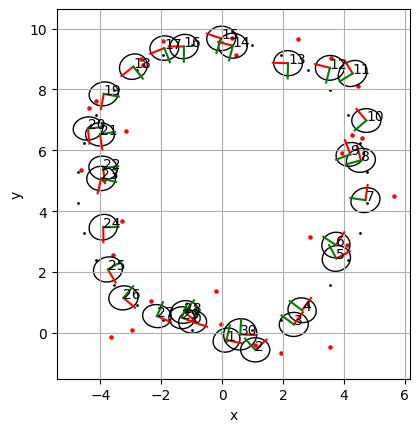

In [127]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('x'); ax.set_ylabel('y'); 
ax.set_aspect('equal'); ax.grid()

for p_gt in history["gt"]:
    ax.scatter(p_gt.x(), p_gt.y(), color = 'k', s = 1)
for z in history["z"]:
    ax.scatter(z[0],z[1],color='r', s = 5)

for i in range(len(history["dr"])):
    p_est = result.atPose2(X(i))
    p_est_cov = marginals.marginalCovariance(X(i))
    plot_pose(ax, p_est, p_est_cov, 0.5)
    ax.text(p_est.x(),p_est.y(), i)